# PC-Hopfield Network
Purpose: To try training a recurrent PC network as a Hopfield network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import copy
%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
np.set_printoptions(edgeitems=30, linewidth=250, formatter=dict(float=lambda x: "% .4f" % x))

In [4]:
def Hamming(X, Y):
    '''
     H = Hamming(X, Y)
     
     Computes the Hamming distance between rows of X and Y.
     If X and/or Y have multiple rows, then the output will
     be an array.
     
     Inputs:
      X   (M,D) array
      Y   (N,D) array
      
     Output:
      H   (M,N) array
    '''
    H = np.zeros((len(X), len(Y)), dtype=int)
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            H[i,j] = torch.sum(x*y<=0.)
    return H

def Perturb(x, p=0., n=0):
    '''
        y = Perturb(x, p=0., n=0)
        
        Apply binary noise to x. With probability p, each bit will be randomly
        set to -1 or 1.
        
        Inputs:
          x is an array of binary vectors of {-1,1}
          p is the probability of each bit being randomly flipped (n=0)
          n is the number of bits to flip (p=0)
        
        Output:
          y is an array of binary vectors of {-1,1}
    '''
    y = copy.deepcopy(x)
    for yy in y:
        if p!=0.:
            for k in range(len(yy)):
                if np.random.rand()<p:
                    yy[k] = Thresh(np.random.randint(2)*2-1)
        if n>0:
            k = np.random.randint(len(yy), size=n)
            yy[k] *= -1
    return y


# Dataset

In [5]:
# class SimpleDataset(Dataset):
#     def __init__(self, A, B, n=300, noise=0.1):
#         self.samples = []
#         n_classes = len(A)
#         for i in range(n):
#             r = np.random.randint(n_classes)
#             sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
#             self.samples.append(sample)
        
#     def __getitem__(self, idx):
#         return self.samples[idx]
        
#     def __len__(self):
#         return len(self.samples)

# Zeta = torch.rand((4,10,))
# print(Zeta)
#blah = SimpleDataset(Zeta, Zeta, n=100, noise=0.0)

In [6]:
class BipolarDataset(Dataset):
    def __init__(self, A, n=300, noise=0.1):
        self.samples = []
        n_classes = len(A)
        for i in range(n):
            r = np.random.randint(n_classes)
            blah = Perturb(A[r], p=0.)
            sample = [blah, blah]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)

In [7]:
# Random binary Vectors
X = np.random.binomial(n=1, p=0.5, size=(4,12))
Zeta = torch.tensor(2*X - 1, dtype=torch.float)
Zeta_c = 10.*Zeta
N = np.shape(Zeta)[1]
print(f'{N} target patterns')
print(f'Hamming Distances:\n{np.array(Hamming(Zeta, Zeta), dtype=int)}')

bipolar_ds = BipolarDataset(Zeta_c, n=30, noise=0.)

12 target patterns
Hamming Distances:
[[0 4 2 3]
 [4 0 6 7]
 [2 6 0 3]
 [3 7 3 0]]


# Create Network

In [8]:
N_neurons = 12
net = PCNetwork.PCNetwork()

net.AddLayer(PCLayer.PCLayer(n=N_neurons))  # 0 (v0)
net.AddLayer(PCLayer.PCLayer(n=N_neurons, type='error'))  # 1 (e1)
net.AddLayer(PCLayer.PCLayer(n=N_neurons))  # 2 (v1)

net.Connect(v_idx=0, e_idx=1, type='1to1')
net.Connect(e_idx=1, v_idx=2, type='1to1')
net.Connect(v_idx=2, e_idx=1, lower_layer=2, type='general', sym=True, act_text='tanh')

net.SetTau(0.05)
net.SetGamma(0.2)

In [9]:
net.con[0].SetIdentity(mult=0.)
net.con[2].SetRandom(random=0.7)
XX = Zeta_c.transpose(1,0)@Zeta_c / N_neurons / 4.
XX -= torch.diag(XX)
net.con[2].SetWeights(XX.clone().detach())

/Users/jorchard/Dropbox/research/pc_network/PCConnection.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.M = torch.tensor(deepcopy(M))


In [10]:
for c in net.con:
    print(c.M_sign)
    print(c.M)

tensor(1.)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor(-1.)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,

In [11]:
for l in net.lyr:
    print(l.bias)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [12]:
#net.Save('my.net')
#net2 = PCNetwork.PCNetwork.Load('my.net')

# Train it

In [13]:
bipolar_ds = BipolarDataset(Zeta_c, n=10, noise=0.)
bipolar_dl = DataLoader(bipolar_ds, batch_size=4, shuffle=True)

In [14]:
bipolar_ds.samples

[[tensor([-10., -10.,  10.,  10., -10., -10.,  10., -10.,  10.,  10.,  10.,  10.]),
  tensor([-10., -10.,  10.,  10., -10., -10.,  10., -10.,  10.,  10.,  10.,  10.])],
 [tensor([-10., -10., -10.,  10.,  10., -10., -10., -10.,  10.,  10.,  10.,  10.]),
  tensor([-10., -10., -10.,  10.,  10., -10., -10., -10.,  10.,  10.,  10.,  10.])],
 [tensor([-10.,  10., -10., -10., -10., -10., -10.,  10., -10.,  10.,  10., -10.]),
  tensor([-10.,  10., -10., -10., -10., -10., -10.,  10., -10.,  10.,  10., -10.])],
 [tensor([-10.,  10., -10., -10., -10., -10., -10.,  10., -10.,  10.,  10., -10.]),
  tensor([-10.,  10., -10., -10., -10., -10., -10.,  10., -10.,  10.,  10., -10.])],
 [tensor([-10., -10., -10.,  10.,  10., -10., -10., -10.,  10.,  10.,  10.,  10.]),
  tensor([-10., -10., -10.,  10.,  10., -10., -10., -10.,  10.,  10.,  10.,  10.])],
 [tensor([-10., -10.,  10.,  10., -10., -10.,  10., -10.,  10.,  10.,  10.,  10.]),
  tensor([-10., -10.,  10.,  10., -10., -10.,  10., -10.,  10.,  10.,  

In [15]:
net.Reset()
net.Learn(bipolar_dl, T=1., epochs=10)

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


In [16]:
net.lyr[1].bias

tensor([-4.3214, -2.7751, -2.4092,  4.0084, -2.0342, -4.3136, -2.4051, -2.7765,
         4.0108,  5.5565,  5.5578, -0.1196])

In [17]:
net.con[2].M

tensor([[ -4.3207,  -6.9450,  -6.5738,  -8.4866,  -6.2043,  -4.3226,  -6.5745,
          -6.9449,  -8.4871, -11.1112, -11.1116,  -8.4577],
        [ -8.3335,  -5.8333,  -8.3333, -10.8335,  -8.3334,  -8.3334,  -8.3334,
          -5.8334, -10.8335,  -8.3333,  -8.3333,  -8.3333],
        [ -0.8642,  -1.3890,   2.6852,  -1.6973,  -3.2408,  -0.8645,   2.6851,
          -1.3889,  -1.6974,  -2.2223,  -2.2223,   0.3084],
        [ -8.3332, -10.8333,  -8.3334,  -5.8332,  -8.3333,  -8.3333,  -8.3334,
         -10.8335,  -5.8332,  -8.3333,  -8.3333,  -8.3334],
        [ -1.7283,  -2.7780,  -4.6295,  -3.3946,   3.5183,  -1.7291,  -4.6298,
          -2.7779,  -3.3948,  -4.4446,  -4.4446,   0.6169],
        [ -4.3207,  -6.9450,  -6.5738,  -8.4866,  -6.2043,  -4.3226,  -6.5745,
          -6.9449,  -8.4871, -11.1112, -11.1116,  -8.4577],
        [ -0.8642,  -1.3890,   2.6852,  -1.6973,  -3.2408,  -0.8645,   2.6851,
          -1.3889,  -1.6974,  -2.2223,  -2.2223,   0.3084],
        [ -8.3335,  -5.8333

## Test it

In [18]:
net.Reset()

In [19]:
foo = Zeta_c.clone().detach() / 1.
net.SetInput(foo)
net.lyr[-1].SetState(foo, random=0.01)
foo = Perturb(foo, n=2)
net.lyr[-1].SetState(foo)
#net.lyr[-1].ResetState(random=0.1)
net.lyr[0].Clamped(True)
net.lyr[-1].Clamped(False)
net.lyr[1].ResetState(random=0.1)

In [20]:
Hamming(foo, Zeta_c)

array([[2, 2, 4, 5],
       [4, 2, 6, 7],
       [4, 6, 2, 3],
       [3, 5, 3, 2]])

In [21]:
net.lyr[-1].x

tensor([[-10., -10., -10., -10., -10., -10., -10.,  10.,  10.,  10.,  10., -10.],
        [ 10.,  10., -10., -10., -10., -10., -10.,  10.,  10.,  10.,  10., -10.],
        [-10.,  10., -10.,  10.,  10., -10.,  10., -10.,  10.,  10.,  10.,  10.],
        [-10., -10., -10., -10., -10., -10.,  10., -10.,  10.,  10.,  10.,  10.]])

In [22]:
net.lyr[0].Probe(True)
net.lyr[1].Probe(True)
net.lyr[2].Probe(True)
net.Learning(False)

In [23]:
net.Run(1., dt=0.001)

In [ ]:
net.Plot(idx=0);

In [1174]:
Hamming(Zeta_c, net.lyr[-1].x)

array([[ 2,  5, 12,  5],
       [ 5,  0,  7,  6],
       [ 7,  6,  3,  6],
       [ 7,  6,  7,  0]])

In [1129]:
net.con[2].sigma() @ net.con[2].M

tensor([[-29.1667,  37.5000, -12.5000, -29.1667, -37.5000,  45.8333, -45.8333,
         -45.8333,  37.5000,  12.5000,  20.8333,  37.5000],
        [ -5.1658,  28.7621,  -4.9907,  -5.1658, -29.7463,  37.3407, -38.3248,
         -38.3248,  12.7602,  20.0085,  28.5871,  12.7602],
        [ 29.1667, -37.5000,  12.5000,  29.1667,  37.5000, -45.8333,  45.8333,
          45.8333, -37.5000, -12.5000, -20.8333, -37.5000],
        [  4.1686, -37.4801, -45.8194,   4.1686,   4.1707,  12.5139, -45.8234,
         -45.8234,  12.5159, -37.4861,  12.5080,  12.5159]])

In [1130]:
net.lyr[-1].x

tensor([[-29.1666,  37.5000, -12.5000, -29.1666, -37.5000,  45.8333, -45.8334,
         -45.8334,  37.5000,  12.5000,  20.8334,  37.5000],
        [ -5.1412,  28.7621,  -4.9680,   2.2734, -29.7463,  37.3407, -38.3249,
         -38.3249,  -1.5899,  20.0085,  28.5871,  12.7601],
        [ 29.1666, -37.5000,  12.5000,  29.1666,  37.5000, -45.8333,  45.8334,
          45.8334, -37.5000, -12.5000, -20.8334, -37.5000],
        [  4.1687, -37.4800, -45.8193,   4.1687,   4.1707,  12.5139, -45.8233,
         -45.8233,  12.5159, -37.4860,  12.5080,  12.5159]])

## Many Perturbed Runs

In [922]:
x0 = Zeta_c[1]
ins = torch.vstack((x0, x0, x0, x0, x0, x0))
ins += torch.normal(torch.zeros_like(ins))

In [923]:
net.Reset()
net.SetInput(ins)
net.lyr[-1].SetState(ins)
#net.lyr[-1].ResetState(random=0.1)
net.lyr[0].Clamped(True)
net.lyr[-1].Clamped(False)
net.lyr[1].ResetState(random=0.1)

In [924]:
net.Run(1., dt=0.001)

In [925]:
net.lyr[-1].x

tensor([[-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
          15000.2666,  25000.4453,  25000.4453,  15000.2666, -45000.7852,
           5000.0864, -45000.7852],
        [-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
          15000.2666,  25000.4453,  25000.4473,  15000.2666, -45000.7852,
           5000.0864, -45000.7852],
        [-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
          15000.2666,  25000.4473,  25000.4473,  15000.2666, -45000.7852,
           5000.0864, -45000.7852],
        [-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
          15000.2666,  25000.4473,  25000.4473,  15000.2666, -45000.7852,
           5000.0864, -45000.7852],
        [-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
          15000.2666,  25000.4453,  25000.4473,  15000.2666, -45000.7852,
           5000.0864, -45000.7852],
        [-55000.9922, -45000.7852,   5000.0864, -55000.9922,  15000.2666,
      

In [926]:
net.con[2].sigma() @ net.con[2].M

tensor([[-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.],
        [-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.],
        [-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.],
        [-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.],
        [-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.],
        [-55000., -45000.,   5000., -55000.,  15000.,  15000.,  25000.,  25000.,
          15000., -45000.,   5000., -45000.]])

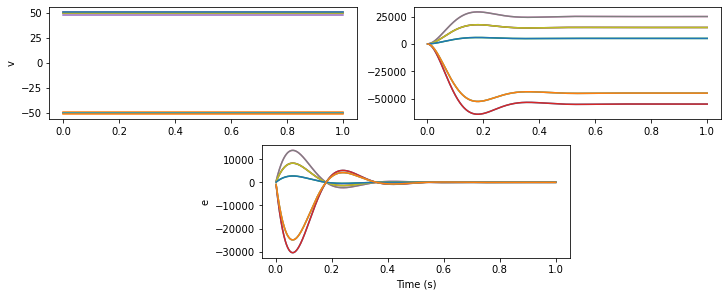

In [927]:
net.Plot();